# Import

In [1]:
# import libraries
import os
import csv
import pickle as pk
import itertools
import time
from collections import defaultdict

import pulp
import numpy as np
import random
import math
from scipy.stats import poisson

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Parameters

In [2]:
# network parameters
net_para = {}

# nodes
net_para['o_nodes'] = [1, 5, 7, 8, 9, 10, 11, 12]
net_para['u_nodes'] = [2, 3, 4, 6]

# links
net_para['o_links'] = [(1, 2), (1, 5), (1, 6),
                       (5, 9),
                       (7, 8), (7, 11), (7, 12),
                       (8, 12),
                       (9, 10), (9, -1),
                       (10, 9), (10, 11),
                       (11, 12),
                       (12, -1)]
net_para['u_links'] = [(2, 3),
                       (3, 7),
                       (4, 3), (4, 8),
                       (6, 7), (6, 10)]

# neighbors
net_para['neighbors'] = defaultdict(list)
for start, end in net_para['o_links']+net_para['u_links']:
    net_para['neighbors'][start].append(end)

# arrival rates
net_para['arr_rates'] = {1: [10, 0.5],
                         4: [2, 0.5], 
                         10: [6, 0.5]}

# capacities
net_para['capacities'] = defaultdict(lambda:5)

In [3]:
sim_para = {}
sim_para['sample_num'] = 5
sim_para['time_horizon'] = 5000

sim_para['observation_slots'] = []
sim_para['method'] = 'Null'

# file operations
sim_para['path'] = ("T" + str(sim_para['time_horizon']) + 
                    "_SN" + str(sim_para['sample_num']) + '/')
os.makedirs(sim_para['path'], exist_ok=True)

# Network

In [4]:
class Network:

    # initialization
    def __init__(self, net_para):
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.ao_nodes = [node for node in self.a_nodes if node in self.o_nodes]
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        self.neighbors = net_para['neighbors']
        # states
        self.A = {node:0 for node in self.a_nodes}
        self.Q = {node:0 for node in self.o_nodes+self.u_nodes}
        self.X = {node:0 for node in self.u_nodes}
        self.Y = {node:0 for node in self.u_nodes}
        # actions
        self.m = {node:0 for node in self.a_nodes}
        self.f = {link:0 for link in self.o_links+self.u_links}
        self.g = {link:0 for link in self.u_links}
        # records of states
        self.A_log = {node:[] for node in self.a_nodes}
        self.Q_log = {node:[] for node in self.o_nodes+self.u_nodes}
        self.X_log = {node:[] for node in self.u_nodes}
        self.Y_log = {node:[] for node in self.u_nodes}
        # records of actions
        self.m_log = {node:[] for node in self.a_nodes}
        self.f_log = {link:[] for link in self.o_links+self.u_links}
        self.g_log = {link:[] for link in self.u_links}

    # receive external arrivals
    def Arrive(self, arr): 
        for node in self.a_nodes:
            self.A[node] = arr[node]
        return
        
    # admit packets into the network
    def Admit(self, adm, adm_u):
        # update overlay nodes
        for node in self.ao_nodes:
            self.m[node] = adm[node]
            self.Q[node] += adm[node]
        # update underlay nodes
        for node in self.au_nodes:
            self.m[node] = adm_u[node]
            self.Q[node] += adm_u[node]
            self.X[node] += adm_u[node]
        return

        # service
    def Serve(self, ser, ser_u):
        for start, end in self.o_links+self.u_links:
            # overlay -> overlay
            if start in self.o_nodes and end in self.o_nodes:
                self.f[(start, end)] = min(ser[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                self.Q[end] += self.f[(start, end)]
            # overlay -> underlay
            elif start in self.o_nodes and end in self.u_nodes:
                self.f[(start, end)] = min(ser[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                # overlay -> real underlay
                self.Q[end] += self.f[(start, end)]
                # overlay -> imaginary underlay
                self.X[end] += self.f[(start, end)]
            # overlay -> sink
            elif start in self.o_nodes and end == -1:
                self.f[(start, end)] = min(ser[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)] 
            # underlay -> overlay
            elif start in self.u_nodes and end in self.o_nodes:
                # real underlay -> overlay
                self.f[(start, end)] = min(ser_u[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                self.Q[end] += self.f[(start, end)]
                # imaginary underlay -> overlay
                self.g[(start, end)] = min(ser[(start, end)], self.X[start])
                self.X[start] -= self.g[(start, end)]
            # underlay -> underlay
            elif start in self.u_nodes and end in self.u_nodes:
                # real underlay -> real underlay
                self.f[(start, end)] = min(ser_u[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)]
                self.Q[end] += self.f[(start, end)]
                # imaginary underlay -> imaginary underlay
                self.g[(start, end)] = min(ser[(start, end)], self.X[start])
                self.X[start] -= self.g[(start, end)]
                self.X[end] += self.g[(start, end)]
            # underlay -> sink
            elif start in self.u_nodes and end == -1:
                # real underlay -> sink
                self.f[(start, end)] = min(ser_u[(start, end)], self.Q[start])
                self.Q[start] -= self.f[(start, end)] 
                # imaginary underlay -> sink
                self.g[(start, end)] = min(ser[(start, end)], self.X[start])
                self.X[start] -= self.g[(start, end)] 
        return
    
    # update the gap
    def UpdateY(self):
        for node in self.u_nodes:
            self.Y[node] = max(self.Q[node] - self.X[node], 0)
        return

    # record 
    def Record(self):
        # record A
        for node in self.a_nodes:
            self.A_log[node].append(self.A[node])
        # record Q
        for node in self.o_nodes+self.u_nodes:
            self.Q_log[node].append(self.Q[node])
        # record X and Y
        for node in self.u_nodes:
            self.X_log[node].append(self.X[node])
            self.Y_log[node].append(self.Y[node])
        # record m
        for node in self.a_nodes:
            self.m_log[node].append(self.m[node])
        # record f
        for link in self.o_links+self.u_links:
            self.f_log[link].append(self.f[link])
        # record g
        for link in self.u_links:
            self.g_log[link].append(self.g[link])
        return

# Simulation

In [5]:
class Simulation:
    
    # initialization
    def __init__(self, net_para, sim_para):
        self.net_para = net_para
        self.sim_para = sim_para
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        # simulation parameters
        self.sample_num = sim_para['sample_num']
        self.time_horizon = sim_para['time_horizon']
        self.method = sim_para['method']
        self.observation_slots = sim_para['observation_slots']
        # records of queues
        self.A_log_samples = []
        self.Q_log_samples = []
        self.X_log_samples = []
        self.Y_log_samples = []
        # records of actions
        self.m_log_samples = []
        self.f_log_samples = []
        self.g_log_samples = []
    
    # main process of simulation
    def Simulate(self):
        for sample_idx in range(self.sample_num): 
            start_time = time.time()
            net = Network(self.net_para)
            solver = self.Solver()
            gen = Generator(self.net_para, self.sim_para)
            for t in range(self.time_horizon):
                # arrival
                arr = gen.GenArr(t, net.Q)
                net.Arrive(arr)
                # update Y
                if t in self.observation_slots:
                    net.UpdateY()
                # calculate actions
                adm, ser = solver.Service(net.A, net.Q, net.X, net.Y)   
                # packet admission
                adm_u = gen.GenAdmU(t)
                net.Admit(adm, adm_u)
                # service
                ser_u = gen.GenSerU(t, net.Q)
                net.Serve(ser, ser_u)
                # record
                net.Record()                
                # display process
                if t % 100 == 99:
                    print('\r' + self.method + ', sample index = ' + str(sample_idx) + ', t = ' + str(t) + ', ' + str(time.time()-start_time), end='')
                    if t == self.time_horizon - 1:
                        print('\r')
            # record results
            self.A_log_samples.append(net.A_log)
            self.Q_log_samples.append(net.Q_log)
            self.X_log_samples.append(net.X_log)
            self.Y_log_samples.append(net.Y_log)
            self.m_log_samples.append(net.m_log)
            self.f_log_samples.append(net.f_log)
            self.g_log_samples.append(net.g_log)
        return
    
    # initialize the solver
    def Solver(self):
        if self.method[:3] == 'TDP':
            return TDP(self.net_para, self.sim_para)
        elif self.method == 'Rand':
            return Randomized()
        elif self.method[:2] == 'DP':
            return DP(self.net_para, self.sim_para)
        else:
            return Null()
    
    # calculate the total queue backlogs
    def CalTotalQueue(self):
        total_queue = [0] * self.time_horizon
        for t in range(self.time_horizon):
            for sample_idx in range(self.sample_num):
                total_queue[t] += sum(self.Q_log_samples[sample_idx][node][t] for node in self.o_nodes+self.u_nodes)/self.sample_num
        return total_queue
    
    # calculate the average utility
    def CalAveUtility(self):
        ave_utility = [0] * self.time_horizon
        for t in range(self.time_horizon):
            utility = 0
            for sample_idx in range(self.sample_num): 
                utility += sum(self.m_log_samples[sample_idx][node][t] for node in self.a_nodes)/self.sample_num
                ave_utility[t] = (ave_utility[t-1]*t + utility)/(t+1)
        return ave_utility

# Generator

In [6]:
class Generator:
    
    # initialization
    def __init__(self, net_para, sim_para):
        self.arr_rates = net_para['arr_rates']
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.u_nodes = net_para['u_nodes']
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.u_links = net_para['u_links']
        self.time_horizon = sim_para['time_horizon']
        # generate stochastic arrival sequences
        self.arr_seq = {}
        for node in self.a_nodes:
            num, prob = self.arr_rates[node]
#             self.arr_seq[node] = np.random.choice([0, num], self.time_horizon, p = [1-prob, prob])
            self.arr_seq[node] = np.random.randint(0, 2*num*prob+1, self.time_horizon)
    
    # generate external arrivals
    def GenArr(self, t, Q):
        arr = {}
        for node in self.a_nodes:
            arr[node] = self.arr_seq[node][t]
        # inject malicious arrival into the node with the largest backlog
        _, max_node = max([(Q[node], node) for node in self.a_nodes])
        arr[max_node] += 10
        return arr
    
    # generate underlay admissions (admit all packets)
    def GenAdmU(self, t):
        adm_u = {}
        for node in self.au_nodes:
            adm_u[node] = self.arr_seq[node][t]
        return adm_u
    
    # generate underlay services
    def GenSerU(self, t, Q):
        ser_u = {link: 0 for link in self.u_links}
        # node 2: service rate drops in the mid way
        ser_u[(2, 3)] = 5 if t < self.time_horizon//2 else 2
        # node 3
        ser_u[(3, 7)] = 5
        # node 4: JLQ
        if Q[3] >= Q[8]:
            ser_u[(4, 3)] = 5
        else:
            ser_u[(4, 8)] = 5
        # node 6: JLQ
        if Q[7] >= Q[10]:
            ser_u[(6, 7)] = 5
        else:
            ser_u[(6, 10)] = 5
        return ser_u

# Solvers

## TDP

In [7]:
class TDP:
    
    # initialization
    def __init__(self, net_para, sim_para):
        # network parameters
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.ao_nodes = [node for node in self.a_nodes if node in self.o_nodes]
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        self.capacities = net_para['capacities']
        # simulation parameters
        method_para = sim_para['method'].split('_')
        self.coeV = float(method_para[1]) # the coefficient of V
        self.alpha = float(method_para[2]) # if equal to -1, means need to learn
        self.is_V_known = (method_para[3] == 'T')
        self.t = 0
        self.est_T = 1
        # initialize variable m's
        self.m = {}
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=0, cat='Integer')
        # initialize variable f's
        self.f = {}
        for link in self.o_links:
            self.f[link] = pulp.LpVariable('f'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize variable g's
        self.g = {}
        for link in self.u_links:
            self.g[link] = pulp.LpVariable('g'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize the solver
        self.solver = pulp.PULP_CBC_CMD(msg=False)

    # compute the action
    def Service(self, A, Q, X, Y):
        # determine V
        if self.is_V_known:
            V = self.coeV
        else:
            if self.t >= self.est_T: self.est_T *= 2
            V = self.coeV * self.est_T**((1+self.alpha)/2)
        # formulate the problem
        problem = self.Formulate(A, Q, X, Y, V)
        # solve the problem
        problem.solve(self.solver)
        # get the result for admission
        adm = {}
        for node in self.ao_nodes:
            val = pulp.value(self.m[node])
            adm[node] = int(val) if val != None else 0
        # get the result for service
        ser = {}
        for link in self.o_links:
            val = pulp.value(self.f[link])
            ser[link] = int(val) if val != None else 0
        for link in self.u_links:
            val = pulp.value(self.g[link])
            ser[link] = int(val) if val != None else 0
        ser[(9, -1)] = self.capacities[(9, -1)]
        ser[(12, -1)] = self.capacities[(12, -1)]    
        self.t += 1
        return adm, ser
        
    # initialize the problem
    def Formulate(self, A, Q, X, Y, V):
        # update variable m's
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=A[node], cat='Integer')
        # formulate the problem
        problem = pulp.LpProblem("TDP", pulp.LpMinimize)
        problem += (
            Q[1] * (self.m[1] - self.f[(1, 2)] - self.f[(1, 5)] - self.f[(1, 6)]) + 
            Q[5] * (self.f[(1, 5)] - self.f[(5, 9)]) + 
            Q[7] * (self.g[(3, 7)] + self.g[(6, 7)] - self.f[(7, 8)] - self.f[(7, 11)] - self.f[(7, 12)]) + 
            Q[8] * (self.g[(4, 8)] + self.f[(7, 8)] - self.f[(8, 12)]) + 
            Q[9] * (self.f[(5, 9)] + self.f[(10, 9)] - self.f[(9, 10)]) + 
            Q[10] * (self.m[10] + self.g[(6, 10)] + self.f[(9, 10)] - self.f[(10, 9)] - self.f[(10, 11)]) + 
            Q[11] * (self.f[(7, 11)] + self.f[(10, 11)] - self.f[(11, 12)]) + 
            Q[12] * (self.f[(7, 12)] + self.f[(8, 12)] + self.f[(11, 12)]) + 
            X[2] * (self.f[(1, 2)] - self.g[(2, 3)]) +  
            X[3] * (self.g[(2, 3)] + self.g[(4, 3)] - self.g[(3, 7)]) + 
            X[4] * (-self.g[(4, 3)] - self.g[(4, 8)]) +
            X[6] * (self.f[(1, 6)] - self.g[(6, 7)] - self.g[(6, 10)]) - 
            Y[2] * (- self.g[(2, 3)]) -
            Y[3] * (self.g[(2, 3)] + self.g[(4, 3)] - self.g[(3, 7)]) -
            Y[4] * (-self.g[(4, 3)] - self.g[(4, 8)]) -
            Y[6] * (-self.g[(6, 7)] - self.g[(6, 10)])
            - V * self.m[1]
            - V * self.m[10]
        ), "Z"
        return problem

## Randomized

In [8]:
class Randomized:
    
    # initialization
    def __init__(self):
        return
    
    # compute the action
    def Service(self, *_):
        # 1 -> 6 -> 11 -> d
        ser = defaultdict(int)
        ser[(1, 6)] = 5
        ser[(6, 11)] = 5
        ser[(11, -1)] = 5
        # 3 -> 4 -> 5 -> d
        ser[(3, 4)] = 5
        ser[(4, 5)] = 5
        ser[(5, -1)] = 5
        # 12 -> 7
        # 14 -> 15 -> d
        # 10 -> 15 -> d
        ser[(12, 7)] = 5
        ser[(7, 8)] = 5
        ser[(14, 15)] = 5
        ser[(10, 15)] = 5
        ser[(15, -1)] = 5

        return ser

## DP

In [9]:
class DP:
    
 # initialization
    def __init__(self, net_para, sim_para):
        # network parameters
        self.a_nodes = list(net_para['arr_rates'].keys())
        self.o_nodes = net_para['o_nodes']
        self.u_nodes = net_para['u_nodes']
        self.ao_nodes = [node for node in self.a_nodes if node in self.o_nodes]
        self.au_nodes = [node for node in self.a_nodes if node in self.u_nodes]
        self.o_links = net_para['o_links']
        self.u_links = net_para['u_links']
        self.capacities = net_para['capacities']
        # simulation parameters
        method_para = sim_para['method'].split('_')
        self.coeV = float(method_para[1]) # the coefficient of V
        self.alpha = float(method_para[2]) # if equal to -1, means need to learn
        self.is_V_known = (method_para[3] == 'T')
        self.t = 0
        self.est_T = 1
        # initialize variable m's
        self.m = {}
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=0, cat='Integer')
        # initialize variable f's
        self.f = {}
        for link in self.o_links:
            self.f[link] = pulp.LpVariable('f'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize variable g's
        self.g = {}
        for link in self.u_links:
            self.g[link] = pulp.LpVariable('g'+'_'+str(link[0])+'_'+str(link[1]), lowBound=0, 
                                           upBound=self.capacities[link], cat='Integer')
        # initialize the solver
        self.solver = pulp.PULP_CBC_CMD(msg=False)

    # compute the action
    def Service(self, A, Q, X, Y):
        # determine V
        if self.is_V_known:
            V = self.coeV
        else:
            if self.t >= self.est_T: self.est_T *= 2
            V = self.coeV * self.est_T**((1+self.alpha)/2)
        # formulate the problem
        problem = self.Formulate(A, Q, X, Y, V)
        # solve the problem
        problem.solve(self.solver)
        # get the result for admission
        adm = {}
        for node in self.ao_nodes:
            val = pulp.value(self.m[node])
            adm[node] = int(val) if val != None else 0
        # get the result for service
        ser = {}
        for link in self.o_links:
            val = pulp.value(self.f[link])
            ser[link] = int(val) if val != None else 0
        for link in self.u_links:
            val = pulp.value(self.g[link])
            ser[link] = int(val) if val != None else 0
        ser[(9, -1)] = self.capacities[(9, -1)]
        ser[(12, -1)] = self.capacities[(12, -1)]
        self.t += 1
        return adm, ser
        
    # initialize the problem
    def Formulate(self, A, Q, X, Y, V):
        # update variable m's
        for node in self.ao_nodes:
            self.m[node] = pulp.LpVariable('m'+'_'+str(node), lowBound=0, 
                                           upBound=A[node], cat='Integer')
        # formulate the problem
        problem = pulp.LpProblem("DP", pulp.LpMinimize)
        problem += (
            Q[1] * (self.m[1] - self.f[(1, 2)] - self.f[(1, 5)] - self.f[(1, 6)]) + 
            Q[5] * (self.f[(1, 5)] - self.f[(5, 9)]) + 
            Q[7] * (- self.f[(7, 8)] - self.f[(7, 11)] - self.f[(7, 12)]) + 
            Q[8] * (self.f[(7, 8)] - self.f[(8, 12)]) + 
            Q[9] * (self.f[(5, 9)] + self.f[(10, 9)] - self.f[(9, 10)]) + 
            Q[10] * (self.m[10] + self.f[(9, 10)] - self.f[(10, 9)] - self.f[(10, 11)]) + 
            Q[11] * (self.f[(7, 11)] + self.f[(10, 11)] - self.f[(11, 12)]) + 
            Q[12] * (self.f[(7, 12)] + self.f[(8, 12)] + self.f[(11, 12)])
            - V * self.m[1]
            - V * self.m[10]
        ), "Z"
        return problem

## Null

In [10]:
class Null:
    
    # initialization
    def __init__(self):
        return
    
    # compute the action
    def Service(self, *_):
        return defaultdict(int) 

# Compare Policies

In [11]:
# methods
methods = ['TDP_1_0_T', 'TDP_10_0_T', 'TDP_25_0_T', 'TDP_0.5_0_F', 'DP_10_0_T']
# methods = ['TDP_1_0_T', 'TDP_10_0_T', 'TDP_25_0_T', 'TDP_0.5_0_F']

In [101]:
# run
sim_para['observation_slots'] = [t for t in range(0, sim_para['time_horizon'], 10)]
for method in methods:
    sim_para['method'] = method
    sim = Simulation(net_para, sim_para)
    sim.Simulate()
    pk.dump(sim.CalTotalQueue(), open(sim_para['path'] + 'Q_' + method, "wb"))
    pk.dump(sim.CalAveUtility(), open(sim_para['path'] + 'U_' + method, "wb"))

TDP_1_0_T, sample index = 0, t = 4999, 114.59070873260498
TDP_1_0_T, sample index = 1, t = 4999, 113.45758748054504
TDP_1_0_T, sample index = 2, t = 4999, 115.13286304473877
TDP_1_0_T, sample index = 3, t = 4999, 113.66942644119263
TDP_1_0_T, sample index = 4, t = 4999, 113.60962677001953
TDP_10_0_T, sample index = 0, t = 4999, 114.61491560935974
TDP_10_0_T, sample index = 1, t = 4999, 114.54859256744385
TDP_10_0_T, sample index = 2, t = 4999, 114.09188675880432
TDP_10_0_T, sample index = 3, t = 4999, 114.57752704620361
TDP_10_0_T, sample index = 4, t = 4999, 114.85813927650452
TDP_25_0_T, sample index = 0, t = 4999, 114.41383528709412
TDP_25_0_T, sample index = 1, t = 4999, 114.23219966888428
TDP_25_0_T, sample index = 2, t = 4999, 114.88457536697388
TDP_25_0_T, sample index = 3, t = 4999, 114.59527325630188
TDP_25_0_T, sample index = 4, t = 4999, 114.12007761001587
TDP_0.5_0_F, sample index = 0, t = 4999, 114.66393136978155
TDP_0.5_0_F, sample index = 1, t = 4999, 114.58634424209595


In [12]:
# read data
total_Q_logs = {}
ave_U_logs = {}
for method in methods:
    total_Q_logs[method] = pk.load(open(sim_para['path'] + 'Q_' + method, "rb"))
    ave_U_logs[method] = pk.load(open(sim_para['path'] + 'U_' + method, "rb"))

In [13]:
# parameters for plotting
subSample = sim_para['time_horizon']//100
labelSize = 20
legendSize = 18
figSize = (9, 6)
lineWidth = 2
color_set = ['#E74C3C', '#F1C40F', '#27AE60', '#2980B9', '#E67E22', '#9B59B6']
linestyle_set = ['dashed', 'solid', 'dashdot', (0, (3, 1, 1, 1)), (0, (1, 3, 1)), 'dotted']
t_plot = np.arange(0.0, sim_para['time_horizon'], subSample)

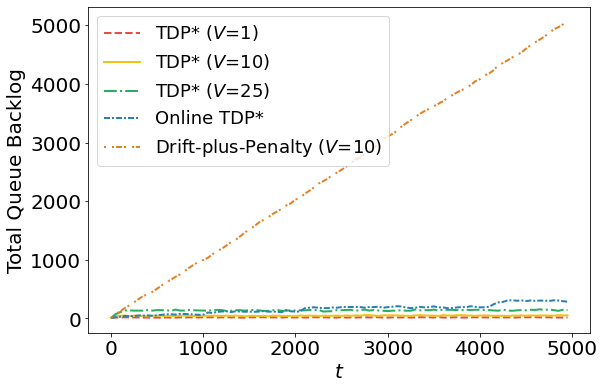

In [14]:
# plot total queue backlogs
fig = plt.figure(figsize=figSize)
ax = fig.gca()
idx = 0
for method in methods:
    total_Q_log = total_Q_logs[method]
    legend = ''
    method_para = method.split('_')
    if method_para[0] == 'TDP':
        if method_para[3] == 'T':
            legend = 'TDP*' + r' ($V$=' + method_para[1] + ')'
        else:
            legend = 'Online TDP*'
    elif method_para[0] == 'DP':
        legend = 'Drift-plus-Penalty' + r' ($V$=' + method_para[1] + ')'
    elif method == 'Rand':
        legend = 'Randomized'
    else:
        legend = 'Null'
    ax.plot(t_plot, total_Q_log[::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label=legend)
    idx += 1

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('$t$', fontsize=labelSize)
plt.ylabel('Total Queue Backlog', fontsize=labelSize)
plt.show()

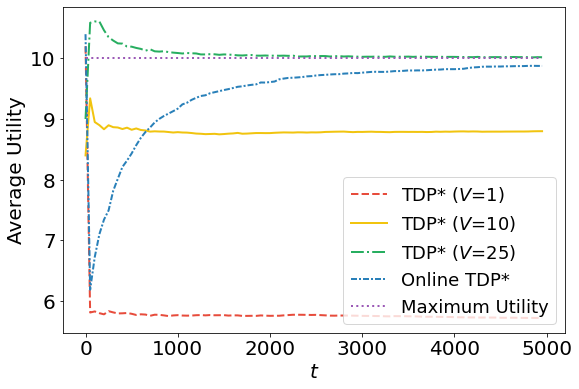

In [18]:
# plot utility
fig = plt.figure(figsize=figSize)
ax = fig.gca()
idx = 0
for method in methods:
    ave_U_log = ave_U_logs[method]
    legend = ''
    method_para = method.split('_')
    if method_para[0] == 'TDP':
        if method_para[3] == 'T':
            legend = 'TDP*' + r' ($V$=' + method_para[1] + ')'
        else:
            legend = 'Online TDP*'
    elif method_para[0] == 'DP':
        legend = 'Drift-plus-Penalty' + r' ($V$=' + method_para[1] + ')'
    elif method == 'Rand':
        legend = 'Randomized'
    else:
        legend = 'Null'
    ax.plot(t_plot, ave_U_log[::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label=legend)
    idx += 1

# plot upper bound
idx += 1
ave_U_upper = [10] * sim_para['time_horizon']
ax.plot(t_plot, ave_U_upper[::subSample], color_set[idx], 
            linewidth=lineWidth, linestyle=linestyle_set[idx], label='Maximum Utility')

# labels
ax.tick_params(labelsize=labelSize)
ax.legend(prop={"size":legendSize})
plt.xlabel('$t$', fontsize=labelSize)
plt.ylabel('Average Utility', fontsize=labelSize)
plt.show()

# Ave Q - Ave U

In [15]:
# methods
coeVs = [i for i in range(1, 251, 1)]
methods = ['TDP_' + str(coeV/10) + '_0_T' for coeV in coeVs]

In [107]:
# run
sim_para['observation_slots'] = [t for t in range(0, sim_para['time_horizon'], 10)]
for method in methods:
    sim_para['method'] = method
    sim = Simulation(net_para, sim_para)
    sim.Simulate()
    pk.dump(sim.CalTotalQueue(), open(sim_para['path'] + 'Q_' + method, "wb"))
    pk.dump(sim.CalAveUtility(), open(sim_para['path'] + 'U_' + method, "wb"))

TDP_0.1_0_T, sample index = 0, t = 4999, 113.84409284591675
TDP_0.1_0_T, sample index = 1, t = 4999, 113.74952816963196
TDP_0.1_0_T, sample index = 2, t = 4999, 114.06486821174622
TDP_0.1_0_T, sample index = 3, t = 4999, 115.30791378021246
TDP_0.1_0_T, sample index = 4, t = 4999, 114.92397141456604
TDP_0.2_0_T, sample index = 0, t = 4999, 115.42344164848328
TDP_0.2_0_T, sample index = 1, t = 4999, 114.06132745742798
TDP_0.2_0_T, sample index = 2, t = 4999, 113.25832080841064
TDP_0.2_0_T, sample index = 3, t = 4999, 114.23433613777162
TDP_0.2_0_T, sample index = 4, t = 4999, 114.04338383674622
TDP_0.3_0_T, sample index = 0, t = 4999, 113.59107780456543
TDP_0.3_0_T, sample index = 1, t = 4999, 114.15964865684509
TDP_0.3_0_T, sample index = 2, t = 4999, 113.84850215911865
TDP_0.3_0_T, sample index = 3, t = 4999, 113.62338161468506
TDP_0.3_0_T, sample index = 4, t = 4999, 114.18696570396423
TDP_0.4_0_T, sample index = 0, t = 4999, 113.94990754127502
TDP_0.4_0_T, sample index = 1, t = 4999,

TDP_5.5_0_T, sample index = 2, t = 4999, 109.74221158027649
TDP_5.5_0_T, sample index = 3, t = 4999, 111.44975590705872
TDP_5.5_0_T, sample index = 4, t = 4999, 110.60261249542236
TDP_5.6_0_T, sample index = 0, t = 4999, 110.44364595413208
TDP_5.6_0_T, sample index = 1, t = 4999, 110.54493784904482
TDP_5.6_0_T, sample index = 2, t = 4999, 109.97235894203186
TDP_5.6_0_T, sample index = 3, t = 4999, 110.55464911460876
TDP_5.6_0_T, sample index = 4, t = 4999, 109.97408056259155
TDP_5.7_0_T, sample index = 0, t = 4999, 110.74163937568665
TDP_5.7_0_T, sample index = 1, t = 4999, 109.99569106101997
TDP_5.7_0_T, sample index = 2, t = 4999, 110.82305002212524
TDP_5.7_0_T, sample index = 3, t = 4999, 110.22593593597412
TDP_5.7_0_T, sample index = 4, t = 4999, 110.40812730789185
TDP_5.8_0_T, sample index = 0, t = 4999, 110.48747611045837
TDP_5.8_0_T, sample index = 1, t = 4999, 110.03274273872375
TDP_5.8_0_T, sample index = 2, t = 4999, 110.45550394058228
TDP_5.8_0_T, sample index = 3, t = 4999,

TDP_10.9_0_T, sample index = 3, t = 4999, 110.34744930267334
TDP_10.9_0_T, sample index = 4, t = 4999, 111.13227963447571
TDP_11.0_0_T, sample index = 0, t = 4999, 110.81798839569092
TDP_11.0_0_T, sample index = 1, t = 4999, 110.77140259742737
TDP_11.0_0_T, sample index = 2, t = 4999, 110.75006651878357
TDP_11.0_0_T, sample index = 3, t = 4999, 110.64536046981812
TDP_11.0_0_T, sample index = 4, t = 4999, 111.14174771308899
TDP_11.1_0_T, sample index = 0, t = 4999, 110.53274917602539
TDP_11.1_0_T, sample index = 1, t = 4999, 111.29058027267456
TDP_11.1_0_T, sample index = 2, t = 4999, 110.67845201492319
TDP_11.1_0_T, sample index = 3, t = 4999, 110.90477705001831
TDP_11.1_0_T, sample index = 4, t = 4999, 111.25193881988525
TDP_11.2_0_T, sample index = 0, t = 4999, 111.27156972885132
TDP_11.2_0_T, sample index = 1, t = 4999, 111.32354068756104
TDP_11.2_0_T, sample index = 2, t = 4999, 111.56264925003052
TDP_11.2_0_T, sample index = 3, t = 4999, 111.74854445457458
TDP_11.2_0_T, sample ind

TDP_16.3_0_T, sample index = 1, t = 4999, 149.89209079742432
TDP_16.3_0_T, sample index = 2, t = 4999, 149.18044805526733
TDP_16.3_0_T, sample index = 3, t = 4999, 150.47886252403263
TDP_16.3_0_T, sample index = 4, t = 4999, 152.97934079170227
TDP_16.4_0_T, sample index = 0, t = 4999, 149.80535340309143
TDP_16.4_0_T, sample index = 1, t = 4999, 149.83478069305423
TDP_16.4_0_T, sample index = 2, t = 4999, 151.23434853553772
TDP_16.4_0_T, sample index = 3, t = 4999, 148.51213717460632
TDP_16.4_0_T, sample index = 4, t = 4999, 151.99673008918762
TDP_16.5_0_T, sample index = 0, t = 4999, 152.10527038574222
TDP_16.5_0_T, sample index = 1, t = 4999, 150.03348422050476
TDP_16.5_0_T, sample index = 2, t = 4999, 149.31049633026123
TDP_16.5_0_T, sample index = 3, t = 4999, 151.74464058876038
TDP_16.5_0_T, sample index = 4, t = 4999, 151.58433532714844
TDP_16.6_0_T, sample index = 0, t = 4999, 150.40264964103703
TDP_16.6_0_T, sample index = 1, t = 4999, 152.50534296035767
TDP_16.6_0_T, sample ind

TDP_21.6_0_T, sample index = 4, t = 4999, 114.95821189880371
TDP_21.7_0_T, sample index = 0, t = 4999, 115.12891197204594
TDP_21.7_0_T, sample index = 1, t = 4999, 114.82362985610962
TDP_21.7_0_T, sample index = 2, t = 4999, 114.89046764373784
TDP_21.7_0_T, sample index = 3, t = 4999, 114.77943706512451
TDP_21.7_0_T, sample index = 4, t = 4999, 115.06699419021606
TDP_21.8_0_T, sample index = 0, t = 4999, 114.84629797935486
TDP_21.8_0_T, sample index = 1, t = 4999, 114.84564018249512
TDP_21.8_0_T, sample index = 2, t = 4999, 114.97933125495917
TDP_21.8_0_T, sample index = 3, t = 4999, 115.22318553924566
TDP_21.8_0_T, sample index = 4, t = 4999, 114.95493364334106
TDP_21.9_0_T, sample index = 0, t = 4999, 114.52885055541992
TDP_21.9_0_T, sample index = 1, t = 4999, 115.15387177467346
TDP_21.9_0_T, sample index = 2, t = 4999, 114.80203914642334
TDP_21.9_0_T, sample index = 3, t = 4999, 114.95586633682251
TDP_21.9_0_T, sample index = 4, t = 4999, 114.95900082588196
TDP_22.0_0_T, sample ind

In [16]:
# read data
Q_U = []
for method in methods:
    total_Q = pk.load(open(sim_para['path'] + 'Q_' + method, "rb"))
    ave_U = pk.load(open(sim_para['path'] + 'U_' + method, "rb"))
    Q_U.append((total_Q[-1], ave_U[-1]))

In [17]:
# parameters for plotting
labelSize = 20
legendSize = 18
figSize = (9, 6)
lineWidth = 2

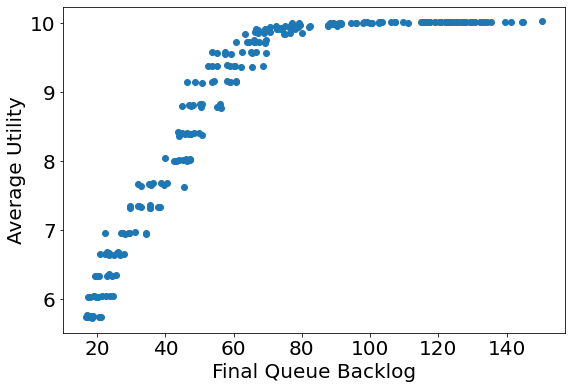

In [21]:
# scatter plot
fig = plt.figure(figsize=figSize)
ax = fig.gca()
plt.scatter([pair[0] for pair in Q_U], [pair[1] for pair in Q_U])

# q_plot = np.arange(20, 150, 1)
# u_plot = [10 - 1000/q**2 for q in q_plot]
# ax.plot(q_plot, u_plot, '#9B59B6', linewidth=lineWidth, linestyle='solid')

# labels
ax.tick_params(labelsize=labelSize)
# ax.legend(prop={"size":legendSize})
plt.xlabel('Final Queue Backlog', fontsize=labelSize)
plt.ylabel('Average Utility', fontsize=labelSize)
plt.show()